## Propensity Score Matching 
In Propensity Score Matching (PSM), we aim to estimate the Conditional Average Treatment Effect (CATE) — the effect of a treatment (e.g., a mindset intervention) on individuals based on their characteristics (covariates)
Define the Problem:

* Treatment: Whether a student received the intervention (1 = Yes, 0 = No).
* Outcome: What we want to measure (e.g., test score improvement).
* Covariates: Characteristics like age, gender, and prior performance that may influence both treatment and outcome.

Example: Alice received the treatment, her test score improved by 10 points. Bob did not receive the treatment, his score improved by 5 points.

## Estimate Propensity Scores:
We use logistic regression to estimate the probability (propensity score) that each student receives the treatment based on their covariates.

Example: Alice has a high propensity score (e.g., 0.85), and Bob has a low score (e.g., 0.25).

### Matching:
We match treated students (like Alice) with control students (like Charlie) who have similar propensity scores (e.g., Charlie’s score is 0.82, but he didn’t receive the treatment).

This helps compare students who are similar except for whether they got the treatment.

### Estimate CATE:
For each matched pair, we calculate the difference in outcomes. Example: Alice’s test score improved by 10 points, and Charlie’s improved by 7. So, the treatment effect for Alice is 10 - 7 = 3points.
We do this for all matched pairs and take the average to get the overall CATE.

Example: If other students had treatment effects of 2 and 4 points, the average CATE might be:

Average CATE= (3+2+4)/3 = 3

This means, on average, the intervention increased test score improvements by 3 points.

To estimate the Conditional Average Treatment Effect (CATE) using Propensity Score Matching (PSM) on the the synthetic data regarding mindsets of student:

    * Preprocess the data (loading and handling covariates).
    * Estimate the propensity scores using logistic regression.
    * Perform Propensity Score Matching (PSM) using nearest-neighbor matching.
    * Estimate the CATE by comparing the outcomes of matched treated and control groups

CATE for each individual:0      -0.087619
1       0.332323
2       0.439673
3      -0.133548
4       0.513476
          ...   
3379    0.546582
3380    0.040908
3381   -0.295373
3382   -0.163854
3383    0.022409
Name: Y, Length: 3384, dtype: float64
Estimated CATE: 0.2558249286643359


c:\Users\dell\OneDrive\Desktop\Thesis\CATE_Estimation_using_Meta_Learners\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


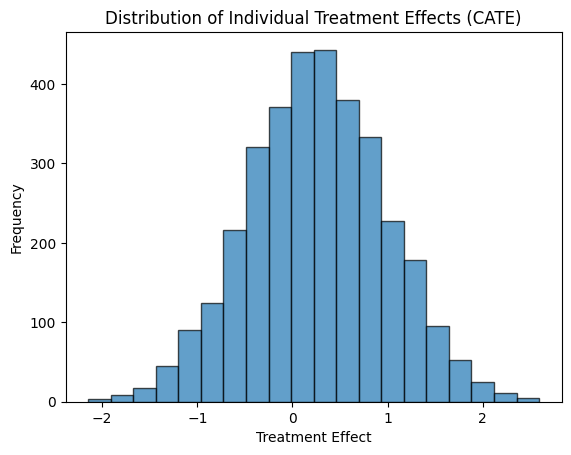

In [6]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Load the dataset
data = pd.read_csv('../data/dataset.csv')

# Define the treatment, covariates, and outcome
# Assuming 'treatment' is the column representing the intervention, 'outcome' is the effect we're measuring, and other columns are covariates.
treatment_col = 'Z'  
outcome_col = 'Y' 

# Define covariates (excluding the treatment and outcome columns)
covariates = data.drop(columns=[treatment_col, outcome_col])

# Step 1: Estimate the propensity score using logistic regression
logistic_model = LogisticRegression()
logistic_model.fit(covariates, data[treatment_col])

# Predict the propensity scores
data['propensity_score'] = logistic_model.predict_proba(covariates)[:, 1]

# Step 2: Perform Propensity Score Matching (PSM) - Nearest Neighbor Matching
# Separate the treated and control groups
treated = data[data[treatment_col] == 1]
control = data[data[treatment_col] == 0]

# Matching on the propensity score
# Find nearest neighbors in control group for each treated individual
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])

# Step 3: Match treated individuals with control individuals based on nearest neighbors
matched_control = control.iloc[indices.flatten()]

# Step 4: Estimate CATE
# Calculate the difference in the outcome between matched treated and control individuals 
# The condition for this CATE is that the treated and control individuals have similar characteristics 
# (covariates) based on their propensity scores
cate = treated[outcome_col].reset_index(drop=True) - matched_control[outcome_col].reset_index(drop=True)

print(f"CATE for each individual:{cate}")
# Print the average CATE
average_cate = cate.mean()
print(f"Estimated CATE: {average_cate}")

# Optionally: Explore the distribution of the individual treatment effects
import matplotlib.pyplot as plt
plt.hist(cate, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of Individual Treatment Effects (CATE)')
plt.xlabel('Treatment Effect')
plt.ylabel('Frequency')
plt.show()
